# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
% matplotlib inline

In [4]:
archived = pd.read_csv("twitter-archive-enhanced.csv")

In [5]:
archived.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [6]:
archived.shape

(2356, 17)

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [7]:
import requests
import os

In [8]:
# Create data in the root folder
folder_name = '.'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [9]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [10]:
with open(os.path.join(folder_name, url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)

In [11]:
predictions = pd.read_csv("image-predictions.tsv", sep="\t")

In [12]:
predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [13]:
predictions.shape

(2075, 12)

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [14]:
import json
data_list = []
with open('tweet-json.txt', encoding='utf-8') as file:
    for f in file:
        data = json.loads(f)
        data_list.append({'tweet_id': data["id"],
                            'retweet_count': data["retweet_count"],
                            'favorite_count': data["favorite_count"],
                            'retweeted': data['retweeted']
                         })
new_tweets = pd.DataFrame(data_list, columns = ['tweet_id', 'retweet_count', 'favorite_count', 'retweeted'])

In [15]:
new_tweets.head()

,tweet_id,retweet_count,favorite_count,retweeted
0,892420643555336193,8853,39467,False
1,892177421306343426,6514,33819,False
2,891815181378084864,4328,25461,False
3,891689557279858688,8964,42908,False
4,891327558926688256,9774,41048,False


In [16]:
new_tweets.shape

(2354, 4)

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [17]:
archived

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [18]:
predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [19]:
new_tweets

,tweet_id,retweet_count,favorite_count,retweeted
0,892420643555336193,8853,39467,False
1,892177421306343426,6514,33819,False
2,891815181378084864,4328,25461,False
3,891689557279858688,8964,42908,False
4,891327558926688256,9774,41048,False
5,891087950875897856,3261,20562,False
6,890971913173991426,2158,12041,False
7,890729181411237888,16716,56848,False
8,890609185150312448,4429,28226,False
9,890240255349198849,7711,32467,False


In [20]:
archived.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [21]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [22]:
new_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
retweeted         2354 non-null bool
dtypes: bool(1), int64(3)
memory usage: 57.5 KB


In [23]:
archived.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [24]:
predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [25]:
new_tweets.describe()

,tweet_id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


In [26]:
archived.sample(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1424,697990423684476929,NaN,NaN,2016-02-12 03:47:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Doug. He's a Draconian Jabbawockee. Ra...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/697990423...,11,10,Doug,None,None,None,None
1735,679729593985699840,NaN,NaN,2015-12-23 18:25:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Hunter. He was playing with his ball m...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679729593...,8,10,Hunter,None,None,None,None


In [27]:
# Save predictions in csv for Visual Inspection
predictions.to_csv("predictions.csv", index=False)

In [28]:
# Save tweet-json data in csv for Visual Inspection
new_tweets.to_csv("new_tweet.csv", index=False)

In [29]:
# Check for total number of null values before making decision
archived["in_reply_to_user_id"].isnull().sum()

2278

In [30]:
# Check for total number of null values before making decision
archived["in_reply_to_user_id"].isnull().sum()

2278

In [31]:
# Check for total number of null values before making decision
archived["retweeted_status_id"].isnull().sum()

2175

In [32]:
# Check for total number of null values before making decision
archived["retweeted_status_user_id"].isnull().sum()

2175

In [33]:
# Check for total number of null values before making decision
archived["retweeted_status_timestamp"].isnull().sum()

2175

In [34]:
# Check for total number of null values before making decision
archived["expanded_urls"].isnull().sum()

59

In [35]:
# Check for rows with null values before making decision
archived[archived["expanded_urls"].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [36]:
# Check for duplicate values
archived["tweet_id"].duplicated().sum()

0

In [37]:
# Check for data distribution
new_tweets["retweet_count"].describe()

count     2354.000000
mean      3164.797366
std       5284.770364
min          0.000000
25%        624.500000
50%       1473.500000
75%       3652.000000
max      79515.000000
Name: retweet_count, dtype: float64

In [38]:
# Check for all duplicate values for any abnormalities
predictions["img_num"].unique()

array([1, 4, 2, 3])

In [39]:
# Check for all duplicate values
archived["text"].duplicated().sum()

0

In [40]:
# Check for all unique values in the name column
archived["name"].unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver', 'Jim',
       'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Lilly',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'a',
       'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack',
       'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow', 'Terrance', 'Aja',
       'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose',
       'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian', 'Walter', 'Sierra',
       'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover', 'Napolean', 'Dawn',
       'Boomer', 'Cody', 'Rumble', 'Clifford', 'quite', 'Dewey', 'Scout',
       'Gizmo', 'Cooper', 'Harold', 'Shikha', 'Jamesy', 'Lili', 'Sammy',
       'Meatball', 'Paisley', 'Albus', 'Neptune', '

In [41]:
# Sort all unique values for easy insppection
pd.Series(archived["name"].unique()).sort_values(ascending=True)

482            Abby
459             Ace
813            Acro
616           Adele
814           Aiden
57              Aja
273           Akumi
410              Al
437          Albert
95            Albus
519         Aldrick
854       Alejandro
219       Alexander
558    Alexanderson
276             Alf
212           Alfie
39             Alfy
122           Alice
671           Amber
618         Ambrose
863             Amy
914          Amélie
318          Anakin
892           Andru
865            Andy
426           Angel
251            Anna
860         Anthony
868          Antony
747          Apollo
           ...     
524            Ziva
464             Zoe
7              Zoey
99            Zooey
798            Zuzu
43                a
492        actually
532             all
391              an
759              by
504         getting
476             his
305      incredibly
591     infuriating
412            just
808            life
836           light
363             mad
429              my


In [42]:
# Check if merging the three tables is important using a common key
same_columns = pd.Series(list(archived) + list(predictions) + list(new_tweets))
same_columns[same_columns.duplicated()]

17    tweet_id
29    tweet_id
dtype: object

In [43]:
# Create a function to calculate the percentage of missing values in `twitter-archive-enhanced-table`
def get_missing_percentage(df, column=""):
    return (df[column].isnull().sum()  / df.shape[0]) * 100

### Quality issues
1. twitter-archive-enhanced table: Missing records in in_reply_to_status_id column

2. twitter-archive-enhanced table: Missing records in in_reply_to_user_id column

3. twitter-archive-enhanced table: Missing records in retweeted_status_id column

4. twitter-archive-enhanced table: Missing records in retweeted_status_user_id column

5. twitter-archive-enhanced table: Missing records in retweeted_status_timestamp column

6. twitter-archive-enhanced table: Missing records in expanded_urls column

7. twitter-archive-enhanced table: Erroneous datatypes in two columns (timestamp and retweeted_status_timestamp)

8. twitter-archive-enhanced table: The dog name column has incorrect values: "None", "such", "a", "an", "the", "this", "all", "by", "his", etc


### Tidiness issues
1.  twitter-archive-enhanced table: One column (type) instead of four columns (doggo, floofer, pupper and puppo) in archived table

2. twitter-archive-enhanced table: tweet_id column in archived table duplicated in new_tweets and predictions tables

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [44]:
# Make copies of original pieces of data
archived_clean = archived.copy()
predictions_clean = predictions.copy()
new_tweets_clean = new_tweets.copy()

### Missing Data

### Issue #1:

`twitter-archive-enhanced` table: Missing records in in_reply_to_status_id column

#### Define: 
Drop in_reply_to_status_id column since over 96.7% (78 out of 2356) of records in this column are missing. The `tweet-json` file was also inspected but they also have the same missing records in the column, so we drop it.

#### Code

In [45]:
get_missing_percentage(df=archived_clean, column=["in_reply_to_status_id"])

in_reply_to_status_id    96.689304
dtype: float64

In [46]:
archived_clean.drop("in_reply_to_status_id", inplace=True, axis=1)

#### Test

In [47]:
archived_clean.columns

Index(['tweet_id', 'in_reply_to_user_id', 'timestamp', 'source', 'text',
       'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

### Issue #2:
`twitter-archive-enhanced`: Missing records in in_reply_to_user_id column

#### Define:
Drop the in_reply_to_user_id column since over 96.7% (78 out of 2356) of records in this column is missing. The `tweet-json` file was also inspected but they also have the same missing records in the column, so we drop it. 

#### Code

In [48]:
get_missing_percentage(df=archived_clean, column=["in_reply_to_user_id"])

in_reply_to_user_id    96.689304
dtype: float64

In [49]:
archived_clean.drop("in_reply_to_user_id", inplace=True, axis=1)

#### Test

In [50]:
archived_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

### Issue #3:
`twitter-archive-enhanced` table: Missing records in retweeted_status_id column

#### Define:
Drop the retweeted_status_id column since over 92.3% (181 out of 2356) of records in this column is missing. The `tweet-json` file was also inspected but they also have the same missing records in the column, so we drop it. 

#### Code:

In [51]:
get_missing_percentage(df = archived_clean, column=["retweeted_status_id"])

retweeted_status_id    92.317487
dtype: float64

In [52]:
archived_clean.drop("retweeted_status_id", inplace=True, axis=1)

#### Test:


In [53]:
archived_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

### Issue #4:
`twitter-archive-enhanced` table: Missing records in retweeted_status_user_id column

#### Define:
Drop the retweeted_status_user_id column since over 92.3% (181 out of 2356) of records in this column is missing. The `tweet-json` file was also inspected but they also have the same missing records in the column, so we drop it. 

#### Code:

In [54]:
get_missing_percentage(df = archived_clean, column=["retweeted_status_user_id"])

retweeted_status_user_id    92.317487
dtype: float64

In [55]:
archived_clean.drop("retweeted_status_user_id", inplace=True, axis=1)

#### Test:

In [56]:
archived_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

### Issue #5:
`twitter-archive-enhanced` table:  Missing records in retweeted_status_timestamp column

#### Define:
Drop the retweeted_status_timestamp column since over 92.3% (181 out of 2356) of records in this column is missing. The `tweet-json` file was also inspected but they also have the same missing records in the column, so we drop it. 

#### Code: 

In [57]:
get_missing_percentage(df = archived_clean, column=["retweeted_status_timestamp"])

retweeted_status_timestamp    92.317487
dtype: float64

In [58]:
archived_clean.drop("retweeted_status_timestamp", inplace=True, axis=1)

#### Test:

In [59]:
archived_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

### Issue #6:
`twitter-archive-enhanced` table: Missing records in expanded_urls column

#### Define:
There are just over 2.5% (2297 out of 2356) records are missing which is not enough to drop the column. However, the urls are not needed for the data analysis (my opinion). This is the reason why we are going to drop it.

#### Code:

In [60]:
get_missing_percentage(df = archived_clean, column=["expanded_urls"])

expanded_urls    2.504244
dtype: float64

In [61]:
archived_clean.drop("expanded_urls", inplace=True, axis=1)

#### Test:

In [62]:
archived_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

### Issue #7:
`twitter-archive-enhanced` table: Erroneous datatypes in two columns (timestamp and retweeted_status_timestamp)

#### Define:
Convert only timestamp column from string to timestamp datatype. retweeted_status_timestamp column has been dropped already


#### Code:

In [63]:
archived_clean['timestamp'] = pd.to_datetime(archived_clean['timestamp'])

#### Test:

In [64]:
archived_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null datetime64[ns]
source                2356 non-null object
text                  2356 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
doggo                 2356 non-null object
floofer               2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 202.5+ KB


### Issue #8:
`twitter-archive-enhanced` table: The dog name column has incorrect values: "None", "such", "a", "an", "the", "this", "all", "by", "his", etc

#### Define:
Extract dog names using regular expression from the text column into the name column but because of the large number of rows and time, I may not be able to extract all names but the template has already been created with scalability in mind


#### Code:

In [65]:
# Function to apply
import re
# Fetch the values that needs to be changed into a Python List
filter_list = ["None","such", "a", "an", "the", "this", "all", "by", "his"]
# The parameters to be matched delimited by |
values = "this is a |this is |this is an | super sleepy | the newly formed | the happiest |HERE is the Rand | squad of | it is | is a | hammer | bad | blond Canadian | Iraqi Speed  | Venezuelan | hello | name is | as a | pup | well-dressed |Meet | is stunning | appreciating the | Saskatoon Black | good to go | fluffy floor | doubt a | his name to | mashmallows | NAME. IS. | with light | name is | puppon a | THIS IS | MAYBE A | will be | Rare Canadian | told his | don\'t rate | good hammerhead | don\'t rate polar | incredible | sugar jar "
def fill_names(archived):
    if archived['name'] in filter_list:
        data = archived['text']
        res = re.search(f'({values})(\w+)', data, re.IGNORECASE)
        if res:
            return res.group(2)
        else:
            return archived['name']
    else:
        return archived['name']

In [66]:
archived_clean['name'] = archived_clean.apply(fill_names, axis=1)  

#### Test:

In [67]:
archived_clean.query(f'name in {filter_list}')[["text","name"]].count()

text    649
name    649
dtype: int64

### Tidy Data

### Issue #1:
One column instead of four columns (doggo, floofer, pupper and puppo) in `twitter-archive-enhanced` table

#### Define:

Melt the a doggo, floofer, pupper and puppo columns to a "type" column

#### Code:

In [68]:
archived_clean = pd.melt(archived_clean, id_vars=['tweet_id', 'timestamp', 'source', 'text',  'rating_numerator', 'rating_denominator', 'name'], value_vars=['doggo', 'floofer', 'pupper', 'puppo'], var_name='type')
# archived_clean = pd.melt(archived_clean, id_vars=['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name'], value_vars=['doggo', 'floofer', 'pupper', 'puppo'], var_name='dog')

In [69]:
archived_clean = archived_clean[archived_clean.value != "None"]
archived_clean.count()

tweet_id              394
timestamp             394
source                394
text                  394
rating_numerator      394
rating_denominator    394
name                  394
type                  394
value                 394
dtype: int64

In [70]:
archived_clean['type'].equals(archived_clean['value'])

True

In [71]:
# Drop the "value" column since they are identical
archived_clean.drop("value", inplace=True, axis=1)

#### Test:

In [72]:
archived_clean[archived_clean["type"]=="puppo"].head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,type
7080,889665388333682689,2017-07-25 01:55:32,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,13,10,None,puppo
7082,889531135344209921,2017-07-24 17:02:04,"<a href=""http://twitter.com/download/iphone"" r...",This is Stuart. He's sporting his favorite fan...,13,10,Stuart,puppo
7139,878776093423087618,2017-06-25 00:45:22,"<a href=""http://twitter.com/download/iphone"" r...",This is Snoopy. He's a proud #PrideMonthPuppo....,13,10,Snoopy,puppo
7162,874012996292530176,2017-06-11 21:18:31,"<a href=""http://twitter.com/download/iphone"" r...",This is Sebastian. He can't see all the colors...,13,10,Sebastian,puppo
7197,867421006826221569,2017-05-24 16:44:18,"<a href=""http://twitter.com/download/iphone"" r...",This is Shikha. She just watched you drop a sk...,12,10,Shikha,puppo


In [73]:
archived_clean["type"].unique()

array(['doggo', 'floofer', 'pupper', 'puppo'], dtype=object)

### Issue #2:
tweet_id column in `twitter-archive-enhanced` table duplicated in `new_tweets` and `predictions` tables

#### Define:
Merge the `twitter-archive-enhanced`, `new_tweets` and `predictions` tables together on tweet_id.

#### Code:

In [74]:
new_tweets_prediction = new_tweets_clean.merge(predictions_clean, on=['tweet_id'], how='inner')

In [75]:
twitter_archive_master = archived_clean.merge(new_tweets_prediction, on=['tweet_id'], how='inner')

#### Test:

In [76]:
twitter_archive_master.shape

(333, 22)

In [77]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 0 to 332
Data columns (total 22 columns):
tweet_id              333 non-null int64
timestamp             333 non-null datetime64[ns]
source                333 non-null object
text                  333 non-null object
rating_numerator      333 non-null int64
rating_denominator    333 non-null int64
name                  333 non-null object
type                  333 non-null object
retweet_count         333 non-null int64
favorite_count        333 non-null int64
retweeted             333 non-null bool
jpg_url               333 non-null object
img_num               333 non-null int64
p1                    333 non-null object
p1_conf               333 non-null float64
p1_dog                333 non-null bool
p2                    333 non-null object
p2_conf               333 non-null float64
p2_dog                333 non-null bool
p3                    333 non-null object
p3_conf               333 non-null float64
p3_dog        

In [78]:
twitter_archive_master.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,type,retweet_count,favorite_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,14,10,Cassie,doggo,7711,32467,...,1,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True
1,884162670584377345,2017-07-09 21:29:42,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,12,10,Yogi,doggo,3128,20771,...,1,German_shepherd,0.707046,True,malinois,0.199396,True,Norwegian_elkhound,0.049148,True
2,872967104147763200,2017-06-09 00:02:31,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very large dog. He has a date later. ...,12,10,doggo,doggo,5669,28031,...,2,Labrador_retriever,0.476913,True,Chesapeake_Bay_retriever,0.174145,True,German_short-haired_pointer,0.092861,True
3,871515927908634625,2017-06-04 23:56:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Napolean. He's a Raggedy East Nicaragu...,12,10,Napolean,doggo,3628,20730,...,2,komondor,0.974781,True,briard,0.020041,True,swab,0.003228,False
4,869596645499047938,2017-05-30 16:49:31,"<a href=""http://twitter.com/download/iphone"" r...",This is Scout. He just graduated. Officially a...,12,10,Scout,doggo,3327,16476,...,1,Chihuahua,0.955156,True,toy_terrier,0.008054,True,muzzle,0.006296,False


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [79]:
twitter_archive_master.to_csv("twitter_archive_master.csv", index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [80]:
twitter_archive_master = pd.read_csv("twitter_archive_master.csv")
twitter_archive_master.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,type,retweet_count,favorite_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,14,10,Cassie,doggo,7711,32467,...,1,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True
1,884162670584377345,2017-07-09 21:29:42,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,12,10,Yogi,doggo,3128,20771,...,1,German_shepherd,0.707046,True,malinois,0.199396,True,Norwegian_elkhound,0.049148,True
2,872967104147763200,2017-06-09 00:02:31,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very large dog. He has a date later. ...,12,10,doggo,doggo,5669,28031,...,2,Labrador_retriever,0.476913,True,Chesapeake_Bay_retriever,0.174145,True,German_short-haired_pointer,0.092861,True
3,871515927908634625,2017-06-04 23:56:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Napolean. He's a Raggedy East Nicaragu...,12,10,Napolean,doggo,3628,20730,...,2,komondor,0.974781,True,briard,0.020041,True,swab,0.003228,False
4,869596645499047938,2017-05-30 16:49:31,"<a href=""http://twitter.com/download/iphone"" r...",This is Scout. He just graduated. Officially a...,12,10,Scout,doggo,3327,16476,...,1,Chihuahua,0.955156,True,toy_terrier,0.008054,True,muzzle,0.006296,False


In [81]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 22 columns):
tweet_id              333 non-null int64
timestamp             333 non-null object
source                333 non-null object
text                  333 non-null object
rating_numerator      333 non-null int64
rating_denominator    333 non-null int64
name                  333 non-null object
type                  333 non-null object
retweet_count         333 non-null int64
favorite_count        333 non-null int64
retweeted             333 non-null bool
jpg_url               333 non-null object
img_num               333 non-null int64
p1                    333 non-null object
p1_conf               333 non-null float64
p1_dog                333 non-null bool
p2                    333 non-null object
p2_conf               333 non-null float64
p2_dog                333 non-null bool
p3                    333 non-null object
p3_conf               333 non-null float64
p3_dog                

### Insights:
1. Determine the Dog type with their average ratings, arranged in descending order

2. The type of dog with the highest retweets

3. The type of dog with the highest favorites/likes 

### Visualizations

1. Plot a bar chart to show the absolute frequency of dog types
2. Plot a bar chart to show the total number of retweets per dog type

In [82]:
# Find the ratings average for fair analysis
twitter_archive_master["rating_average"] = twitter_archive_master["rating_numerator"] / twitter_archive_master["rating_denominator"]

In [83]:
twitter_archive_master.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,type,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,rating_average
0,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,14,10,Cassie,doggo,7711,32467,...,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True,1.4
1,884162670584377345,2017-07-09 21:29:42,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,12,10,Yogi,doggo,3128,20771,...,German_shepherd,0.707046,True,malinois,0.199396,True,Norwegian_elkhound,0.049148,True,1.2
2,872967104147763200,2017-06-09 00:02:31,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very large dog. He has a date later. ...,12,10,doggo,doggo,5669,28031,...,Labrador_retriever,0.476913,True,Chesapeake_Bay_retriever,0.174145,True,German_short-haired_pointer,0.092861,True,1.2
3,871515927908634625,2017-06-04 23:56:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Napolean. He's a Raggedy East Nicaragu...,12,10,Napolean,doggo,3628,20730,...,komondor,0.974781,True,briard,0.020041,True,swab,0.003228,False,1.2
4,869596645499047938,2017-05-30 16:49:31,"<a href=""http://twitter.com/download/iphone"" r...",This is Scout. He just graduated. Officially a...,12,10,Scout,doggo,3327,16476,...,Chihuahua,0.955156,True,toy_terrier,0.008054,True,muzzle,0.006296,False,1.2


### Issue 1:
Dog ratings by type in descending order

In [84]:
twitter_archive_master.groupby("type")["rating_average"].sum().sort_values(ascending=False)

type
pupper     238.1
doggo       94.9
puppo       28.9
floofer      9.5
Name: rating_average, dtype: float64

### Issue 2:
The type of dog with the highest retweets

In [85]:
twitter_archive_master.groupby("type")["retweet_count"].sum().sort_values(ascending=False).index[0]

'doggo'

### Issue 3:
The type of dog with the highest favorites/likes

In [86]:
twitter_archive_master.groupby("type")["favorite_count"].sum().sort_values(ascending=False).index[0]

'pupper'

### Visualization

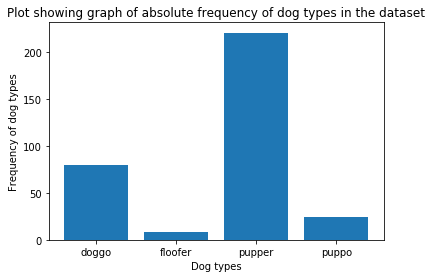

,type
doggo,80
floofer,8
pupper,221
puppo,24


In [108]:
# Plot bar chart for to show the absolute frequency of dog types

# Return the wunique values of dog type
x = sorted(twitter_archive_master["type"].unique())

# Return the type with frequency count of each unique value
y = twitter_archive_master["type"].value_counts().sort_index()

# Plot the graph
plt.bar(x, y)

# Labeling the axes
plt.ylabel("Frequency of dog types");
plt.xlabel("Dog types");
plt.title("Plot showing graph of absolute frequency of dog types in the dataset")

# Display the plot
plt.show()


pd.DataFrame(twitter_archive_master["type"].value_counts().sort_index())